Classifier                  Default Train     Tuned Train    Default Test      Tuned Test     Improvement
------------------------------------------------------------------------------------------
Logistic Regression                0.6044          0.6052          0.5813          0.5813          0.0000
Random Forest                      0.6802          0.6888          0.6469          0.6500          0.0031
SVM                                0.5934          0.6177          0.5563          0.6031          0.0469
AdaBoost                           0.5465          0.5684          0.5437          0.5625          0.0188


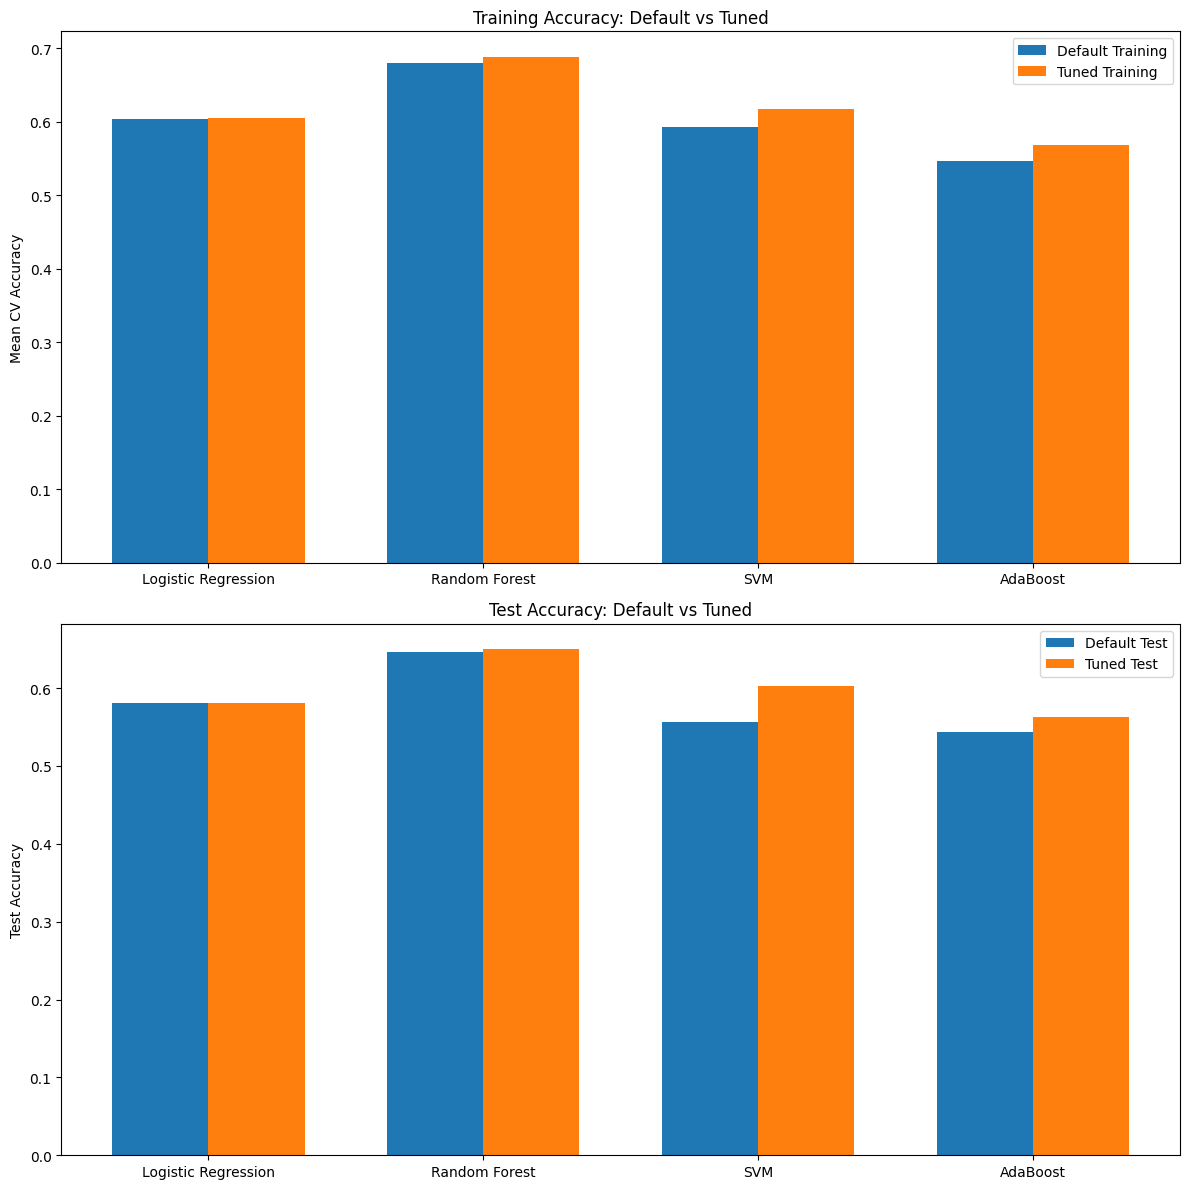

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Load the dataset
data_frame = pd.read_csv('winequality-red.csv')
features = data_frame.drop('quality', axis=1).columns.tolist()
X, y = data_frame[features], data_frame['quality']

# Apply log transformation and standard scaling
def log_transform(X):
    return np.log1p(X)

preprocessor = ColumnTransformer(
    transformers=[
        ('log_transform', FunctionTransformer(log_transform), features),
        ('std_scaler', StandardScaler(), features)
    ]
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Define the models
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=24),
    "Random Forest": RandomForestClassifier(random_state=24),
    "SVM": SVC(random_state=24),
    "AdaBoost": AdaBoostClassifier(random_state=24)
}

# Train and evaluate models with default settings
default_results = {}
for name, clf in classifiers.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    default_results[name] = {
        'Mean CV Accuracy': scores.mean(),
        'Test Accuracy': accuracy_score(y_test, y_pred)
    }

# Hyperparameter search spaces
hyperparameter_spaces = {
    "Logistic Regression": {'classifier__C': Real(0.1, 10, prior='log-uniform')},
    "Random Forest": {'classifier__n_estimators': Integer(100, 1000), 'classifier__max_depth': Integer(10, 100)},
    "SVM": {'classifier__C': Real(0.1, 10, prior='log-uniform'), 'classifier__gamma': Categorical(['scale', 'auto'])},
    "AdaBoost": {'classifier__n_estimators': Integer(50, 500), 'classifier__learning_rate': Real(0.01, 2, prior='log-uniform')}
}

# Train, tune and evaluate models
tuned_results = {}
for name, clf in classifiers.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])
    bayes_search = BayesSearchCV(pipeline, hyperparameter_spaces[name], n_iter=10, cv=5, scoring='accuracy', random_state=24)
    bayes_search.fit(X_train, y_train)
    y_pred = bayes_search.predict(X_test)
    tuned_results[name] = {
        'Mean CV Accuracy': bayes_search.best_score_,
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Best Params': bayes_search.best_params_
    }

# Function to print formatted results
def print_formatted_comparison(default_results, tuned_results):
    print(f"{'Classifier':<25} {'Default Train':>15} {'Tuned Train':>15} {'Default Test':>15} {'Tuned Test':>15} {'Improvement':>15}")
    print("-" * 90)
    for clf in default_results:
        default_train = default_results[clf]['Mean CV Accuracy']
        tuned_train = tuned_results[clf]['Mean CV Accuracy']
        default_test = default_results[clf]['Test Accuracy']
        tuned_test = tuned_results[clf]['Test Accuracy']
        improvement = tuned_test - default_test
        print(f"{clf:<25} {default_train:>15.4f} {tuned_train:>15.4f} {default_test:>15.4f} {tuned_test:>15.4f} {improvement:>15.4f}")

print_formatted_comparison(default_results, tuned_results)

# Function to plot accuracy comparisons
def plot_accuracy_comparisons(default_results, tuned_results):
    classifier_names = list(default_results.keys())
    default_train_acc = [default_results[clf]['Mean CV Accuracy'] for clf in classifier_names]
    tuned_train_acc = [tuned_results[clf]['Mean CV Accuracy'] for clf in classifier_names]
    default_test_acc = [default_results[clf]['Test Accuracy'] for clf in classifier_names]
    tuned_test_acc = [tuned_results[clf]['Test Accuracy'] for clf in classifier_names]

    x = np.arange(len(classifier_names))
    width = 0.35

    fig, ax = plt.subplots(2, 1, figsize=(12, 12))
    ax[0].bar(x - width/2, default_train_acc, width, label='Default Training')
    ax[0].bar(x + width/2, tuned_train_acc, width, label='Tuned Training')
    ax[0].set_ylabel('Mean CV Accuracy')
    ax[0].set_title('Training Accuracy: Default vs Tuned')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(classifier_names)
    ax[0].legend()

    ax[1].bar(x - width/2, default_test_acc, width, label='Default Test')
    ax[1].bar(x + width/2, tuned_test_acc, width, label='Tuned Test')
    ax[1].set_ylabel('Test Accuracy')
    ax[1].set_title('Test Accuracy: Default vs Tuned')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(classifier_names)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

plot_accuracy_comparisons(default_results, tuned_results)
